In [1]:
include("c:/Users/vikra/OneDrive/Desktop/project/src/QuantumDD/QuantumDD.jl")
cd("c:/Users/vikra/OneDrive/Desktop/project")
using Pkg
Pkg.activate(".")
using .QuantumDD, Plots, LsqFit, FFTW, QuantumToolbox, Dates, DelimitedFiles, Printf

  Activating project at `c:\Users\vikra\OneDrive\Desktop\project`


┌ Info: Simulating FID
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:18
Simulating 100%|█████████████████████████████████████████| Time: 0:00:10
┌ Info: T2* for FID: 0.10206883144294365
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:38


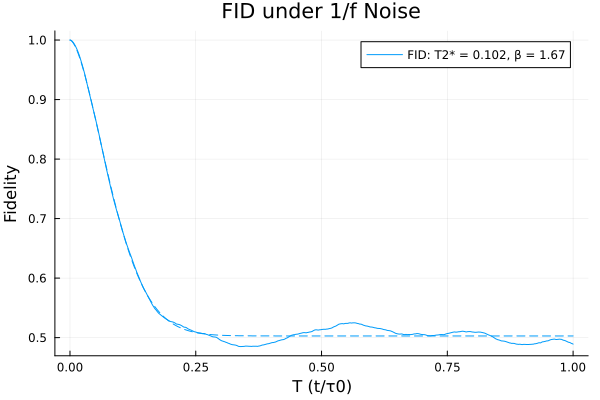

"c:\\Users\\vikra\\OneDrive\\Desktop\\project\\plots\\UDD_1_over_f_FID_20250613_0835.png"

In [ ]:
# Running FID under 1/f noise
sequence = "UDD"
noise_type = "1_over_f" # This name goes in the save file names
T_max = 1.0
n_realizations = 1000
dt = 1e-3   # Time step for simulation
pulse_duration = dt # Pulse duration can't be smaller than dt
σ = 0.025
pulse_shape = "square"
ψ₀ = normalize(basis(2, 0) + basis(2, 1))
initial_guess = [0.01, 1, 0.5]
lower_lims = [0.0, 0.5, 0.0]
# Noise setup
parameters = get_preset_params("1/f")
S_func = ω -> S(ω; parameters...)

# Run baseline FID
@info "Simulating FID"
T_vals, avg_fid = simulate_shaped_control_fidelity(
    ψ₀ = ψ₀,
    T_max = T_max,
    dt = dt,
    target_std_z = σ,
    n_realizations = n_realizations,
    S_func_z = S_func,
)
# Defining the fit model
fit_model(t, p) = p[3] .+ (1 - p[3]) .* exp.(- (t .* abs.(p[1])).^p[2])
fit_fid = curve_fit(fit_model, T_vals, avg_fid, initial_guess;lower=lower_lims)
T2_star = 1/fit_fid.param[1]
β_eff = fit_fid.param[2]
plt = plot(T_vals, avg_fid, label="FID: T2* = $( @sprintf("%.3g", T2_star) ), β = $( @sprintf("%.2f", β_eff) )",
            xlabel="T (t/τ0)", ylabel="Fidelity")
c = plt.series_list[end].plotattributes[:seriescolor]

plot!(plt, T_vals, fit_model(T_vals, fit_fid.param),
      label=false, linestyle=:dash, color=c)
@info "T2* for FID: $T2_star"

plot!(plt, legend=:topright)
title!(plt, "FID under 1/f Noise")
display(plt)

timestamp = Dates.format(now(), "yyyymmdd_HHMM")
savefig("plots/$(sequence)_$(noise_type)_FID_$(timestamp).png")

┌ Info: Simulating UDD with 100 pulses
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:5
Simulating 100%|█████████████████████████████████████████| Time: 0:06:56
┌ Info: T2_eff for UDD with 100 pulses: 0.12888770709212288
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:29
┌ Info: Simulating UDD with 200 pulses
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:5
Simulating 100%|█████████████████████████████████████████| Time: 0:23:08
┌ Info: T2_eff for UDD with 200 pulses: 0.15679162499151433
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:29
┌ Info: Simulating UDD with 400 pulses
└ @ Main c:\Users\vikra\OneDrive\De

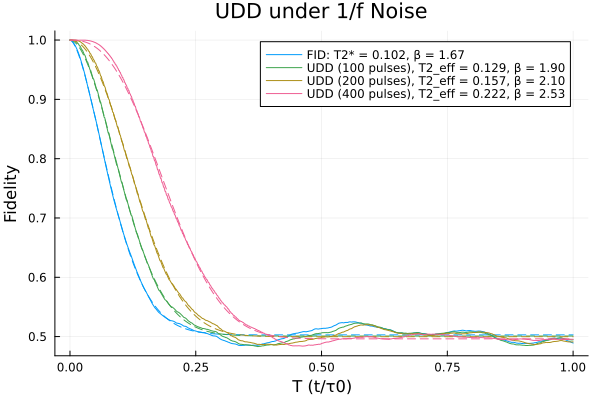

In [ ]:
pulse_counts = [100, 200, 400]#, 600, 800]#, 950]  # Different pulse counts to try
title!(plt, "UDD under 1/f Noise")
# Simulate UDD sequences with different pulse counts
for n_pi_pulses in pulse_counts
    @info "Simulating UDD with $n_pi_pulses pulses"
    control_terms = make_control_terms(sequence, T_max, n_pi_pulses;
        pulse_duration=pulse_duration,
        shape=pulse_shape,
        axis=:x,
        pulse_amplitude=π,
        center_pulse=true
    )

    T_vals_ctrl, avg_fid_ctrl = simulate_shaped_control_fidelity(
        ψ₀ = ψ₀,
        T_max = T_max,
        dt = dt,
        target_std_z = σ,
        n_realizations = n_realizations,
        S_func_z = S_func,
        control_terms = control_terms
    )


    fit_ctrl = curve_fit(fit_model, T_vals_ctrl, avg_fid_ctrl, initial_guess;lower=lower_lims)
    T2_eff = 1/fit_ctrl.param[1] # acts like a decay scale not real T2
    β_eff = fit_ctrl.param[2]
    # plot the fit and the data
    @info "T2_eff for UDD with $n_pi_pulses pulses: $T2_eff"
    plot!(plt, T_vals_ctrl, avg_fid_ctrl,
    label="UDD ($n_pi_pulses pulses), T2_eff = $( @sprintf("%.3g", T2_eff) ), β = $( @sprintf("%.2f", β_eff) )")
    c = plt.series_list[end].plotattributes[:seriescolor]
    plot!(plt, T_vals_ctrl, fit_model(T_vals_ctrl, fit_ctrl.param), linestyle=:dash, label=false, color=c)
    timestamp = Dates.format(now(), "yyyymmdd_HHMM")
    pulse_str = lpad(n_pi_pulses, 4, "0")

    # Save the raw fidelity data
    data_out = hcat(T_vals_ctrl, avg_fid_ctrl, fit_model(T_vals_ctrl, fit_ctrl.param))
    writedlm("data/$(sequence)_$(noise_type)_$(pulse_str)_pulses_data_$(timestamp).csv", 
            data_out, ',')

    # Save the fit params (A = decay rate, β = exponent, offset)
    writedlm("data/$(sequence)_$(noise_type)_$(pulse_str)_pulses_fitparams_$(timestamp).csv", 
            fit_ctrl.param', ',')
    savefig("plots/$(sequence)_$(noise_type)_$(pulse_str)_plot_$(timestamp).png")

end

plot!(plt, legend=:topright)
title!(plt, "UDD under 1/f Noise")
display(plt)

┌ Info: Simulating UDD with 600 pulses
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:5
Simulating 100%|█████████████████████████████████████████| Time: 3:42:49
┌ Info: T2_eff for UDD with 600 pulses: 0.30348457287551983
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:29
┌ Info: Simulating UDD with 800 pulses
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:5
Simulating  79%|█████████████████████████████████        |  ETA: 1:40:38Excessive output truncated after 524293 bytes.

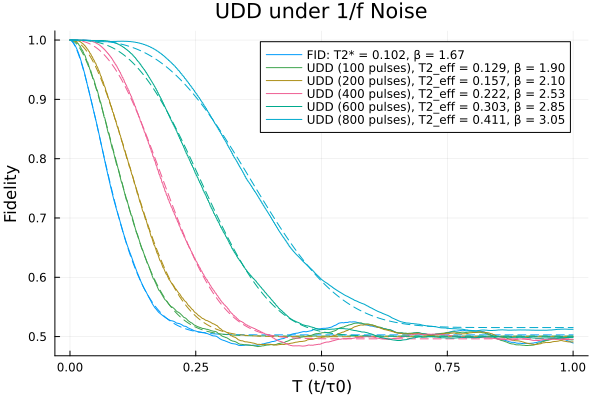

In [4]:
pulse_counts = [600, 800]#, 950]  # Different pulse counts to try
title!(plt, "UDD under 1/f Noise")
# Simulate UDD sequences with different pulse counts
for n_pi_pulses in pulse_counts
    @info "Simulating UDD with $n_pi_pulses pulses"
    control_terms = make_control_terms(sequence, T_max, n_pi_pulses;
        pulse_duration=pulse_duration,
        shape=pulse_shape,
        axis=:x,
        pulse_amplitude=π,
        center_pulse=true
    )

    T_vals_ctrl, avg_fid_ctrl = simulate_shaped_control_fidelity(
        ψ₀ = ψ₀,
        T_max = T_max,
        dt = dt,
        target_std_z = σ,
        n_realizations = n_realizations,
        S_func_z = S_func,
        control_terms = control_terms
    )


    fit_ctrl = curve_fit(fit_model, T_vals_ctrl, avg_fid_ctrl, initial_guess;lower=lower_lims)
    T2_eff = 1/fit_ctrl.param[1] # acts like a decay scale not real T2
    β_eff = fit_ctrl.param[2]
    # plot the fit and the data
    @info "T2_eff for UDD with $n_pi_pulses pulses: $T2_eff"
    plot!(plt, T_vals_ctrl, avg_fid_ctrl,
    label="UDD ($n_pi_pulses pulses), T2_eff = $( @sprintf("%.3g", T2_eff) ), β = $( @sprintf("%.2f", β_eff) )")
    c = plt.series_list[end].plotattributes[:seriescolor]
    plot!(plt, T_vals_ctrl, fit_model(T_vals_ctrl, fit_ctrl.param), linestyle=:dash, label=false, color=c)
    timestamp = Dates.format(now(), "yyyymmdd_HHMM")
    pulse_str = lpad(n_pi_pulses, 4, "0")

    # Save the raw fidelity data
    data_out = hcat(T_vals_ctrl, avg_fid_ctrl, fit_model(T_vals_ctrl, fit_ctrl.param))
    writedlm("data/$(sequence)_$(noise_type)_$(pulse_str)_pulses_data_$(timestamp).csv", 
            data_out, ',')

    # Save the fit params (A = decay rate, β = exponent, offset)
    writedlm("data/$(sequence)_$(noise_type)_$(pulse_str)_pulses_fitparams_$(timestamp).csv", 
            fit_ctrl.param', ',')
    savefig("plots/$(sequence)_$(noise_type)_$(pulse_str)_plot_$(timestamp).png")

end

plot!(plt, legend=:topright)

display(plt)